# 温度预测问题

## 1. 准备工作

### 下载数据

jena气象数据是每10分钟记录与气象有关的14个不同的量值。此处使用2009~2016年之间的数据。共有420551行，每行是一个时间点和对应的数据。

In [1]:
import os

data_dir = '/home/hu/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(lines[0])
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
420551


### 解析数据

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data.shape)
print(float_data[0])

(420551, 14)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


绘制气温的变化图，可以看出气温随时间变化的周期性。

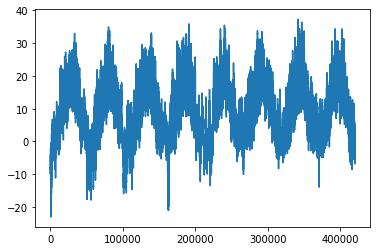

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

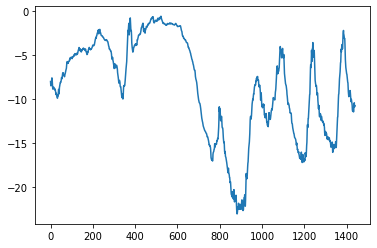

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

### 处理数据

lookback = 720表示给定过去720个时间步的数据，每个时间步是10分钟，720个时间步是过去5天的数据。

steps = 6表示每6个时间步做一次采样，即每一个小时记录一个数据点。

delay = 144表示预测接下来24个小时之后的数据。

需要对数据进行如下两部分操作:

1. 将数据标准化，在相似的范围内取较小的值。

2. 编写python生成器，以当前的浮点数作为输入，并从最近的数据中生成数据批量，同时生成未来的目标温度。（因为样本数据高度冗余，即相邻的样本大部分数值相同，所以显式保存数据会浪费；应该利用原始数据即时生成样本）。

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 准备训练生成器，验证生成器，测试生成器

In [9]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 为了查看整个验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

# # 为了查看整个验证集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 2. 构建基于常识的基准

基准的作用是进行合理性检测，更高级的机器学习模型需要超越基准才能证明有效。

本例中的基准模型是假设温度时间序列是连续的，即始终预测24小时之后的温度与现在的温度相同。

使用平均绝对误差MAE进行评估。

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## 3. 简单的DNN

使用简单的DNN模型，首先用flatten层展平数据，然后通过2个密集连接层处理数据。

最后一个Dense层没有使用激活函数，这对于回归问题比较常见。

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 20s 40ms/step - loss: 1.6457 - val_loss: 0.7610
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.5936 - val_loss: 0.3894
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3093 - val_loss: 0.3085
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2746 - val_loss: 0.3173
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2585 - val_loss: 0.3032
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2489 - val_loss: 0.4147
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2419 - val_loss: 0.3472
Epoch 8/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2336 - val_loss: 0.3246
Epoch 9/20
500/500 [==============================] - 7s 15ms/step - lo

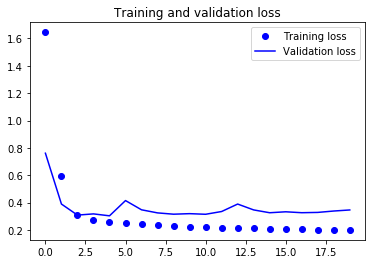

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 4. 使用GRU

GRU是门控循环单元，与LSTM原理基本相同，但是有一些简化，因此运行的计算代价更低。

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 96s 191ms/step - loss: 0.2997 - val_loss: 0.2747
Epoch 2/20
500/500 [==============================] - 93s 186ms/step - loss: 0.2862 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2784 - val_loss: 0.2677
Epoch 4/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2700 - val_loss: 0.2678
Epoch 5/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2672 - val_loss: 0.2660
Epoch 6/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2606 - val_loss: 0.2679
Epoch 7/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2570 - val_loss: 0.2730
Epoch 8/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2527 - val_loss: 0.2701
Epoch 9/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2483 - val_loss: 0.2785
Epoch 10/20
500/500 [==============================] - 93s 185ms/step - l

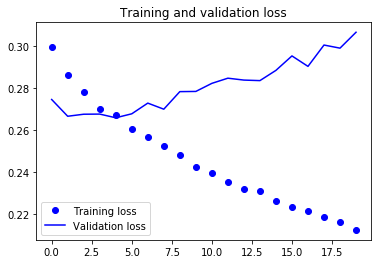

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()